In [ ]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
import torch

# import dependencies for PCA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mlc.data.mnist.dataset import MNIST
from mlc.data.celeba_align.dataset import CelebaAlign
from mlc.util.model import load_checkpoint
import mlc

import argparse
from mlc.model.vae.model import VAE
from mlc.model.cnn_autoencoder.model import CNNAutoencoder
from torchsummary import summary
from mlc.util.model import load_model_from_path

%cd C:/Users/hss19/Documents/GitHub/ml-2025

In [ ]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
torch.cuda.get_device_capability()

2.6.0+cu118
True
11.8
90100


(5, 0)

In [ ]:
# Create parser and add arguments
parser = argparse.ArgumentParser()
CNNAutoencoder.add_arguments(parser)

# Parse empty args to use all defaults
args = parser.parse_args([])

# Convert Namespace to dict
args_dict = vars(args)

args_dict["maxpool"] = True # Set maxpool = True

# Instantiate model with args
#model = CNNAutoencoder(args_dict)


In [ ]:
cae_bce_final = load_model_from_path("models/cnn_autoencoder/20250530002545061406/latest")
cae_mse_final = load_model_from_path("models/cnn_autoencoder/20250530002434334566/latest")

cae_bce_final.eval()
cae_mse_final.eval()

state_dict = torch.load("models/cnn_autoencoder/20250529013539675361/0050/model_state.pt")
cae_bce_pool = CNNAutoencoder(args_dict)
cae_bce_pool.load_state_dict(state_dict)

state_dict = torch.load("models/cnn_autoencoder/20250529013603320968/0050/model_state.pt")
cae_mse_pool = CNNAutoencoder(args_dict)
cae_mse_pool.load_state_dict(state_dict)

cae_bce_pool.eval()
cae_mse_pool.eval()

celeba = CelebaAlign({"scale":64})
validation_data = celeba.get_fold("validation")
test_data = celeba.get_fold("test")

CNNAutoencoder: init_dim=24, layer_dim=24, num_blocks=3
CNNAutoencoder: init_dim=24, layer_dim=24, num_blocks=3
CNNAutoencoder: init_dim=24, layer_dim=24, num_blocks=3
CNNAutoencoder: init_dim=24, layer_dim=24, num_blocks=3


In [ ]:
cae_bce_pool.print_summary()
cae_bce_final.print_summary()

Model: cnn_autoencoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 64, 64]             672
              ReLU-2           [-1, 24, 64, 64]               0
       BatchNorm2d-3           [-1, 24, 64, 64]              48
         MaxPool2d-4           [-1, 24, 32, 32]               0
            Conv2d-5           [-1, 24, 32, 32]           5,208
            Conv2d-6           [-1, 24, 32, 32]           5,208
              ReLU-7           [-1, 24, 32, 32]               0
       BatchNorm2d-8           [-1, 24, 32, 32]              48
         MaxPool2d-9           [-1, 24, 16, 16]               0
           Conv2d-10           [-1, 24, 16, 16]           5,208
           Conv2d-11           [-1, 24, 16, 16]           5,208
             ReLU-12           [-1, 24, 16, 16]               0
      BatchNorm2d-13           [-1, 24, 16, 16]              48
        MaxPool2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.10130681..1.0000002].


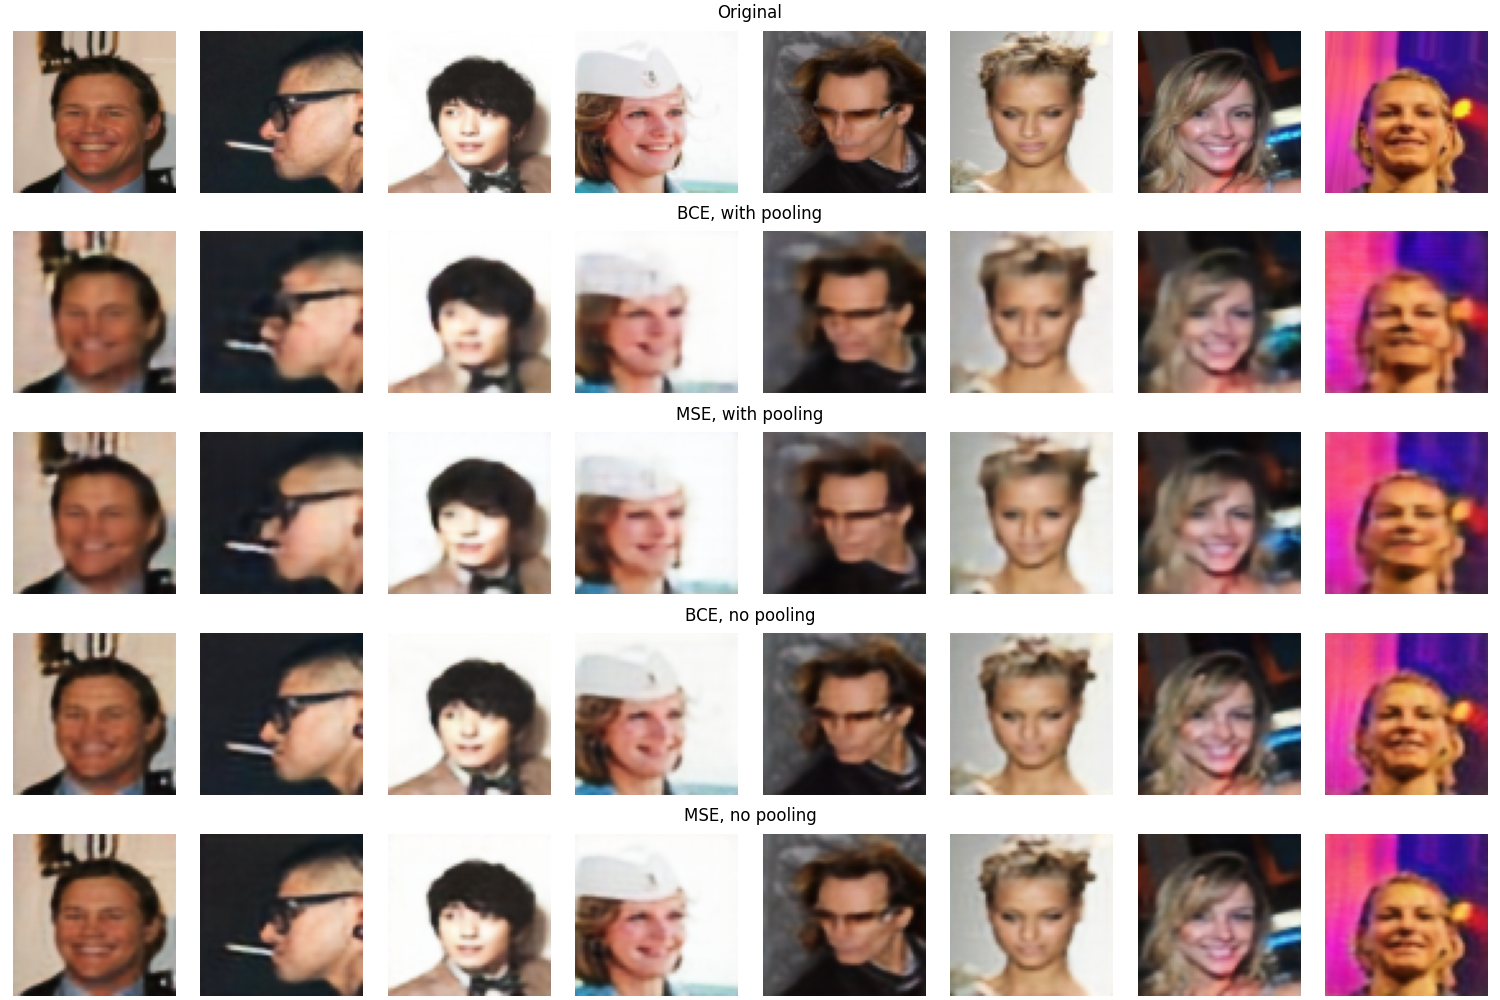

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(15, 10))

subfigures = fig.subfigures(5, 1)
axes = []
for i, subfig in enumerate(subfigures):
    axes.append(subfig.subplots(1,8))
# show some data
for i in range(8):
    data, _ = validation_data[i]
    with torch.no_grad():
        data = data.unsqueeze(0)
        data_rec_bce = cae_bce_final(data)
        data_rec_mse = cae_mse_final(data)
        data_rec_bceP = cae_bce_pool(data)
        data_rec_mseP = cae_mse_pool(data)

        data = data.cpu().squeeze().permute(1,2,0).numpy()
        data_rec_bce = data_rec_bce.cpu().squeeze().permute(1,2,0).numpy()
        data_rec_mse = data_rec_mse.cpu().squeeze().permute(1,2,0).numpy()
        data_rec_bceP = data_rec_bceP.cpu().squeeze().permute(1,2,0).numpy()
        data_rec_mseP = data_rec_mseP.cpu().squeeze().permute(1,2,0).numpy()

    axes[0][i].imshow(data)
    axes[0][i].axis("off")

    axes[1][i].imshow(data_rec_bceP)
    axes[1][i].axis("off")

    axes[2][i].imshow(data_rec_mseP)
    axes[2][i].axis("off")

    axes[3][i].imshow(data_rec_bce)
    axes[3][i].axis("off")

    axes[4][i].imshow(data_rec_mse)
    axes[4][i].axis("off")

subfigures[0].suptitle("Original")
subfigures[1].suptitle("BCE, with pooling")
subfigures[2].suptitle("MSE, with pooling")
subfigures[3].suptitle("BCE, no pooling")
subfigures[4].suptitle("MSE, no pooling")
plt.show()